# Flow Chart For Equity Transparency Calculations 

#### Pip install the package using the link copied from GitHub 

```pip install git+https://github.com/European-Securities-Markets-Authority/esma_data_py.git```         
```pip install pandas, plotly, matplotlib``` 

#### Import libraries

In [ ]:
from  esma_data_py import EsmaDataLoader
import os
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.colors import to_rgb
import pandas as pd
from tqdm import tqdm
from PIL import Image

#### Define color functions 

In [2]:
def hex_to_rgba(hex_color, alpha=1.0):
    """
    Convert a hex color code to an RGBA string.

    Args:
    hex_color (str): A string representing the hex color (e.g., '#RRGGBB').
    alpha (float, optional): The alpha (opacity) value for the color (default is 1.0).

    Returns:
    str: The color in 'rgba(r, g, b, alpha)' format.
    """
    hex_color = hex_color.lstrip('#')  # Remove the '#' if present
    if len(hex_color) != 6:
        raise ValueError("Hex color must be in the format #RRGGBB.")
    r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    return f'rgba({r}, {g}, {b}, {alpha})'


def rgb_to_rgba(rgb_color, alpha=1.0):
    """
    Convert an RGB color string to an RGBA string.

    Args:
    rgb_color (str): A string representing the RGB color (e.g., 'rgb(r, g, b)').
    alpha (float, optional): The alpha (opacity) value for the color (default is 1.0).

    Returns:
    str: The color in 'rgba(r, g, b, alpha)' format.
    """
    # Strip off 'rgb(' and ')'
    rgb_color = rgb_color[rgb_color.find('(')+1:rgb_color.find(')')]
    r, g, b = map(int, rgb_color.split(','))
    return f'rgba({r}, {g}, {b}, {alpha})'


def named_to_rgba(named_color, alpha=1.0):
    """
    Convert a named color to an RGBA string.

    Args:
    named_color (str): The name of the color (e.g., 'red', 'blue').
    alpha (float, optional): The alpha (opacity) value for the color (default is 1.0).

    Returns:
    str: The color in 'rgba(r, g, b, alpha)' format.
    """
    try:
        r, g, b = to_rgb(named_color)
    except ValueError:
        raise ValueError(f"Invalid named color: {named_color}")
    return f'rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, {alpha})'


def convert_to_rgba(color, alpha=1.0):
    """
    Convert a color in different formats (hex, rgb, named) to an RGBA string.

    Args:
    color (str): A color in either hex ('#RRGGBB'), rgb ('rgb(r, g, b)'), or a named color (e.g., 'red').
    alpha (float, optional): The alpha (opacity) value for the color (default is 1.0).

    Returns:
    str: The color in 'rgba(r, g, b, alpha)' format.
    """
    if color.startswith('#'):
        return hex_to_rgba(color, alpha)
    elif color.startswith('rgb'):
        return rgb_to_rgba(color, alpha)
    else:
        return named_to_rgba(color, alpha)


# Concatenate different qualitative color sets from Plotly
colors = px.colors.qualitative.Set1 + \
         px.colors.qualitative.Set2 + \
         px.colors.qualitative.Set3 + \
         px.colors.qualitative.Pastel1 + \
         px.colors.qualitative.Pastel2

# Define the opacity
opacity = 0.3

# Convert each color to RGBA format with the specified opacity
rgba_colors = [convert_to_rgba(color, alpha=opacity) for color in colors]  

#### Define plot and ds functions

In [3]:
def make_sankey_plot(df, id1, id2, value, title='', title_left="<b>Year-1<b>", title_right="<b>Year<b>", opacity=0.3):
    """
    Creates a Sankey plot to visualize the flow of values between two categorical variables in the dataframe.
    
    Parameters:
    - df (pd.DataFrame): Input dataframe containing the data.
    - id1 (str): Column name representing the first category (e.g., previous year).
    - id2 (str): Column name representing the second category (e.g., current year).
    - value (str): Column name representing the values to be visualized in the Sankey plot.
    - title (str, optional): Title for the plot. Defaults to an empty string.
    - title_left (str, optional): Title for the left side of the plot (default is "<b>Year-1<b>").
    - title_right (str, optional): Title for the right side of the plot (default is "<b>Year<b>").
    - opacity (float, optional): Opacity for the Sankey plot colors (default is 0.3).
    
    Returns:
    - fig (plotly.graph_objects.Figure): The Sankey plot figure.
    - data (pd.DataFrame): Dataframe containing the prepared data for the Sankey plot.
    """
    
    # Format the id columns to include 'Year_' as prefix
    id1, id2 = f"Year_{id1}", f"Year_{id2}"

    # Prepare the dataframe by selecting necessary columns and converting to string type
    df = df[[id1, id2, value]].astype(str)

    # Create a sorted list of unique categories from both id1 and id2 columns
    list_thrs_id1 = list(df[id1].value_counts().index)
    list_thrs_id2 = list(df[id2].value_counts().index)
    list_thrs = sorted(set(list_thrs_id1 + list_thrs_id2))

    # Create label dataframes for id1 and id2 categories
    df_lis_label = (pd.DataFrame({id1: list_thrs})
                    .sort_values([id1], ascending=True)
                    .reset_index(drop=True)
                    .assign(id_ = lambda x: x.apply(lambda y: y.name, axis=1))
                    .rename(columns = {'id_': id1 + '_id'}))

    df_lis_fitrs_label = (pd.DataFrame({id2: list_thrs})
                          .sort_values([id2], ascending=True)
                          .reset_index(drop=True)
                          .assign(id_ = lambda x: x.apply(lambda y: y.name + len(df_lis_label.index), axis=1))
                          .rename(columns = {'id_': id2 + '_id'}))
    
    # Define a list of colors for the nodes
    colors = px.colors.qualitative.Set1 + \
             px.colors.qualitative.Set2 + \
             px.colors.qualitative.Set3 + \
             px.colors.qualitative.Pastel1 + \
             px.colors.qualitative.Pastel2
    
    # Ensure we have enough colors to cover all unique categories
    while len(colors) < len(list_thrs):
        colors += colors

    # Convert colors to RGBA format with specified opacity
    rgba_colors = [convert_to_rgba(color, alpha=opacity) for color in colors]
        
    # Prepare color mapping for each category
    df_colors = pd.DataFrame({"list_id": list_thrs,
                              "color": colors[:len(list_thrs)],
                              "color_light": rgba_colors[:len(list_thrs)]})

    # Merge the label dataframes with the color mapping for a final dataframe
    df_colors2 = (pd.concat([df_lis_fitrs_label.rename(columns = {id2: 'list_id', id2 + '_id': 'id_'}),
                             df_lis_label.rename(columns = {id1: 'list_id', id1 + '_id': 'id_'})])              
                     .merge(df_colors, on="list_id", how='left')
                     .sort_values(['id_'], ascending=True))
    
    # Aggregate data and prepare for Sankey plot
    data = (df[[id1, id2, value]].groupby([id1, id2], as_index=False)
                                 .count()
                                 .merge(df_lis_fitrs_label, on=id2, how='left')
                                 .merge(df_lis_label, on=id1, how='left')
                                 .merge(df_colors.rename(columns = {'list_id': id1}), on=id1, how='left'))
    
    # Calculate percentages of items in the same and different buckets (id1 == id2 vs id1 != id2)
    n_isin_same_bucket = sum(data.query(f"{id1} == {id2}")[value]) 
    n_isin_different_bucket = sum(data[value]) - sum(data.query(f"{id1} == {id2}")[value]) 
    pct_isin_same_bucket = n_isin_same_bucket / sum(data[value]) * 100
    pct_isin_different_bucket = n_isin_different_bucket / sum(data[value]) * 100

    # Prepare caption to show in the plot
    add_caption = f"<br>Instruments whose indicator matches : <b>{pct_isin_same_bucket:.1f}%<b> ({n_isin_same_bucket:,.0f})"
    add_caption += f"<br>Instruments whose indicator changes : <b>{pct_isin_different_bucket:.1f}%<b> ({n_isin_different_bucket:,.0f})"
    add_caption += f"<br>Total number of instruments: {sum(data[value]):,.0f}"
    data['matching_ratio'] = pct_isin_same_bucket
    
    # Add the caption to the title
    title = "<b>" + title + "<b>"
    title += add_caption
    
    # Prepare data for Sankey plot
    source = list(data[id2 + '_id'])
    target = list(data[id1 + '_id'])
    values = list(data[value])
    color = list(data['color_light'])

    # Create the Sankey plot using Plotly
    fig = go.Figure(data=[go.Sankey(node = dict(pad = 15,
                                                thickness = 20,
                                                line = dict(color = "black", width = 0.5),
                                                label = list(df_colors2['list_id']),
                                                color = list(df_colors2['color'])),
                                    link = dict(source = source, 
                                                target = target, 
                                                value = values, 
                                                label =  values,
                                                color =  color ))])

    # Update layout of the plot (fonts, size, etc.)
    fig = fig.update_layout(font_size=10,  
                            width=700, 
                            height=700, 
                            plot_bgcolor='white',
                            xaxis={'showgrid': False,
                                   'zeroline': False,
                                   'visible': False},
                            yaxis={'showgrid': False,
                                   'zeroline': False,
                                   'visible': False,},
                            title={'text' : title,
                                   'y': 0.98})
    
    # Add annotations for the titles of the left and right sides of the plot
    for x_coordinate, column_name in enumerate([title_left, title_right]):
        fig = fig.add_annotation(x=x_coordinate,
                                 y=1.05,
                                 xref="x",
                                 yref="paper",
                                 text=column_name,
                                 showarrow=False,
                                 font=dict(size=16),
                                 align="center")

    return fig, data


def create_sankey_datasets(df, year_1, year_2, columns_to_process):
    """
    This function processes a given dataframe to create datasets for Sankey plots and generates the plots themselves 
    for specific columns representing different attributes across two given years.

    Parameters:
    df (pd.DataFrame): The input dataframe containing the data to process.
    year_1 (str): The first year to filter the data (e.g., '2022').
    year_2 (str): The second year to filter the data (e.g., '2023').
    columns_to_process (list): A list of column names that should be processed for creating the Sankey plots.

    Returns:
    sankey_datasets (dict): A dictionary where keys are column names and values are the corresponding processed DataFrames.
    sankey_plots (dict): A dictionary where keys are column names and values are the corresponding Sankey plot objects.
    """

    # Split the data into two datasets based on the years provided
    df_year1 = df.loc[lambda x: x.FrDt.str.startswith(year_1)]
    df_year2 = df.loc[lambda x: x.ToDt.str.startswith(year_2)]
    
    # Initialize dictionaries to store the resulting datasets and plots
    sankey_datasets = {}
    sankey_plots = {}

    # Iterate over the columns to be processed for the Sankey plots
    for column in tqdm(columns_to_process):

        # Create subsets of the data for the current column for each year
        df_year1_subset = df_year1[['Id', column]].rename(columns={column: f'Year_{year_1}'})
        df_year2_subset = df_year2[['Id', column]].rename(columns={column: f'Year_{year_2}'})
        
        # Merge the two subsets on the 'Id' to align the data from both years
        merged_df = pd.merge(df_year1_subset, df_year2_subset, on='Id', how='outer')
        
        # Drop rows where there is missing data for either year
        merged_df = merged_df.dropna(subset=[f'Year_{year_1}', f'Year_{year_2}'])

        # Remove duplicate entries to ensure clean data
        merged_df = merged_df.drop_duplicates()
        
        # Store the cleaned and merged DataFrame for the current column
        sankey_datasets[column] = merged_df

        # Generate the Sankey plot for the merged dataset
        sankey_plot, sk = make_sankey_plot(df=merged_df, 
                                           id1=year_1, 
                                           id2=year_2, 
                                           value="Id", 
                                           title=f"Sankey Plot for {column}", 
                                           title_left=f"<b>Year {year_1}<b>", 
                                           title_right=f"<b>Year {year_2}<b>")

        # Store the generated Sankey plot in the dictionary
        sankey_plots[column] = sankey_plot
    
    # Return the dictionaries containing the datasets and plots
    return sankey_datasets, sankey_plots

def display_saved_img(img_path):
    """
    Changes working directory to '_static' and displays the image at `img_path`.

    Parameters:
    img_path (str): Path to the image file.
    """

    picture_link = Path.cwd().parent / '_static'
    
    if os.path.exists(picture_link):
        os.chdir(picture_link)
    
        img = Image.open(f'{img_path}').convert("RGB")
        display(img)

#### Initialize EsmaDataLoader

In [4]:
# Initialize edl with creation dates to, if not set:
# creation_date_to = Today
# creation_date_from = 2017-01-01

edl = EsmaDataLoader(creation_date_from='2024-03-01', creation_date_to='2024-03-03')

In [5]:
# Load latest files, if no arguments are specified: 

# file_type = 'Full'
# vcap = False (True if dvcap files to retrieve)
# isin = [] 
# cfi = 'E' 
# eqt=True # Determines (If filter for only equity instruments)
# save_locally = False (If True save the returned df on local disc)
# update = False (Parameter used for caching, flag to True when save_locally is True to re download the df as the latest version)

df = edl.load_latest_files()

2025-03-13 17:08:31,610 - EsmaDataLoader - INFO - Requesting fitrs files
2025-03-13 17:08:31,644 - EsmaDataLoader - INFO - Request successful, parsing response
2025-03-13 17:08:31,667 - EsmaDataLoader - INFO - Downloading 1 files
2025-03-13 17:08:31,668 - EsmaDataLoader - INFO - Files will not be saved locally, flag the parameter save_locally=True to save them
2025-03-13 17:08:31,668 - EsmaDataLoader - INFO - Downloading and parsing https://fitrs.esma.europa.eu/fitrs/FULECR_20240302_E_1of1.zip
Parsing file ... : 100%|██████████| 157464/157464 [00:04<00:00, 32070.55it/s]
2025-03-13 17:08:46,835 - EsmaDataLoader - INFO - Process done!


#### Custom preprocessing 

In [6]:
# Custom filtering for this specific process

df = df.query("Mthdlgy == 'YEAR'").query("FrDt >= '2022-01-01'")
df = df.rename(columns={'Id_2': 'RlvntMkt'})

#### Plots creation

In [7]:
# Create plots 

sankey_datasets, sankey_plots = create_sankey_datasets(df=df, 
                                                       year_1="2022", 
                                                       year_2="2023", 
                                                       columns_to_process= ["RlvntMkt", "LrgInScale", "Lqdty"])

100%|██████████| 3/3 [00:00<00:00,  8.29it/s]


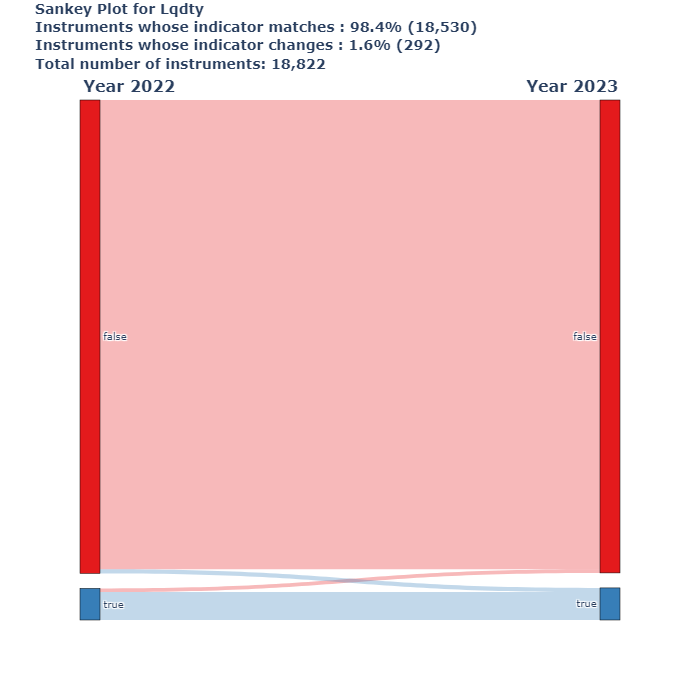

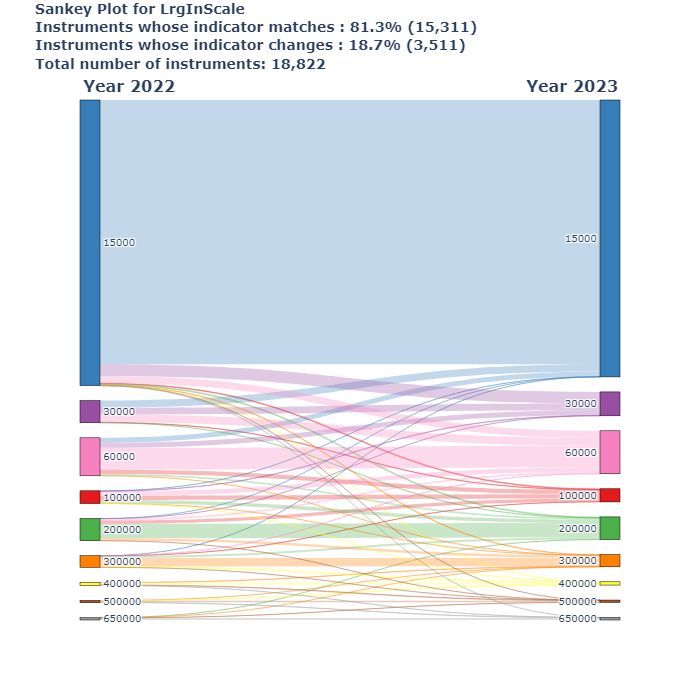

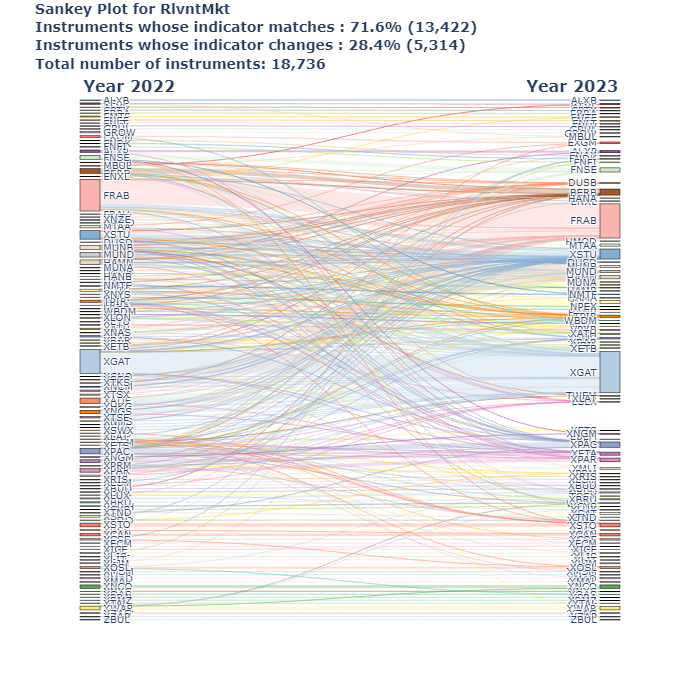

In [8]:
for img in os.listdir(Path.cwd().parent / '_static'):
    display_saved_img(img)